<a href="https://colab.research.google.com/github/FariaParvinMegha/deep_dive_NN/blob/main/micrograd%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# fundamental idea

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


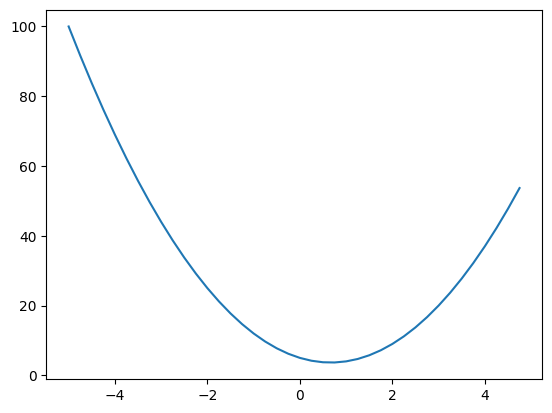

In [ ]:
xs = np.arange(-5, 5, 0.25)
print (xs)

ys = f(xs)
print(ys)

plt.plot(xs, ys)
plt.show()

In [ ]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

a bit more complex

In [ ]:
h = 0.0001

# input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c
print ('d1',d1)
print ('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# main value class

In [156]:
class value:

  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None            #bakcpropegation function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self, other):
    out = value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    out = value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):                                 #activation function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out

  def backward(self):      #creating a master backward function so that u don't have to call bw for each node

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

# showing basic multiplication addition and gradient

In [45]:
a = value(2.0, label= 'a')
b = value(-3.0, label= 'b')
c = value(10.0, label= 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = value(-2.0, label= 'f')
l = d * f; l.label = 'l'
l

value(data=-8.0)

In [43]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

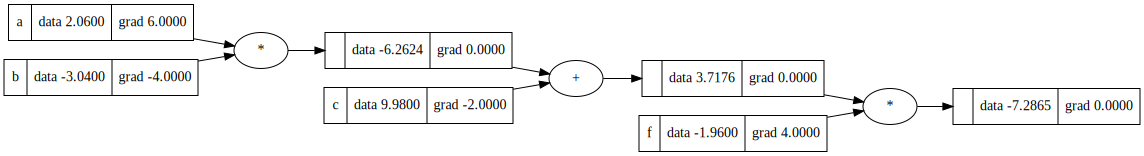

In [54]:
draw_dot(l)

# Adding gradients

adding gradient to each of the nodes. basically doing backpropegation manually. means finding derivatioves of each of the node values with respect to "l". dl/dl, dl/dd, dl/df etc.

In [47]:
### showing how derivatives/backpropegation works numerically/manually

def lol():

  h = 0.001

  a = value(2.0, label= 'a')
  b = value(-3.0, label= 'b')
  c = value(10.0, label= 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = value(-2.0, label= 'f')
  l = d * f; l.label = 'l'
  l1 = l.data

  a = value(2.0, label= 'a')
  b = value(-3.0, label= 'b')
  c = value(10.0, label= 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h
  f = value(-2.0, label= 'f')
  # f.data += h
  l = d * f; l.label = 'l'
  l2 = l.data+h

  print((l2-l1)/h)

lol()

1.000000000000334


In [48]:
f.grad = 4.0    # dl/df = d
d.grad = -2.0   # dl/dd = f
l.grad = 1.0    # dl/dl = 1

In [49]:
# dl/dc = f(gradient of d or leaf of c)
e.grad = -2.0
c.grad = -2.0

from the graph we see, 'plus' basically distributes the gradient of it's parent nodes eually to the leaf node. (assuming graph goes right to left)

In [50]:
# dl/da = bf
# dl/db = af
a.grad = 6.0
b.grad = -4

In [52]:
# now changing a,b,c to change l.
# to increase l, we need to increase it's leaf nodes to the direction of their gradient.
# basically a+h*a.grad something like that.

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
l = d * f

print (l.data)

-7.286496


# A Two layer MLP
most basic example of what happens in a node of a NN

In [152]:
# creating a single node of a neural net that takes two input

# input x1, x2
x1 = value(2.0, label = 'x1')
x2 = value(0.0, label = 'x2')
# weights
w1 = value(-3.0, label = 'w1')
w2 = value(1.0, label = 'w2')
# bias of the neuron
b = value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label = 'o'

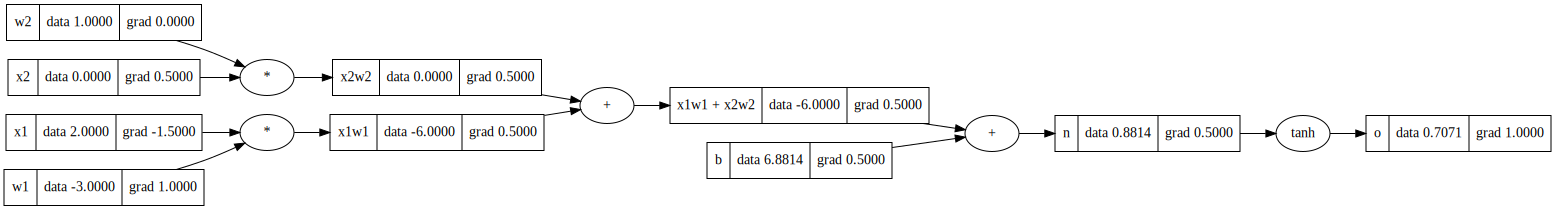

In [155]:
draw_dot(o)

# manually calculating gradients for back propegaton

In [71]:
# o = tanh (n)
# do/dn = 1 - o**2 (1 - tan squared h(n))
# 1 - o.data**2 = 0.5

n.grad = 0.5

In [72]:
o.grad = 1.0

In [74]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [79]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [83]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [84]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [141]:
o.grad = 1.0      #cz in the function definition inital o.grad is set to 0.0. can't backrpopegate if that's 0. so manually setting it to 1.0

# calling backward for each node seperately

In [129]:
o._backward ()

In [117]:
n._backward ()

In [119]:
x1w1x2w2._backward ()
b._backward ()      #nothing will happen cz b is a leaf node

In [121]:
x1w1._backward ()
x2w2._backward ()

# calling backward only once using topological order

In [133]:
# creating topological order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[value(data=6.881373587019543),
 value(data=-3.0),
 value(data=2.0),
 value(data=-6.0),
 value(data=0.0),
 value(data=1.0),
 value(data=0.0),
 value(data=-6.0),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

In [136]:
for node in reversed(topo):
    node._backward()

# calling master backward from class value



In [154]:
o.backward()

fixing bugs

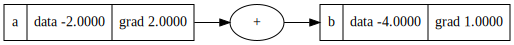

In [159]:
a = value(-2.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

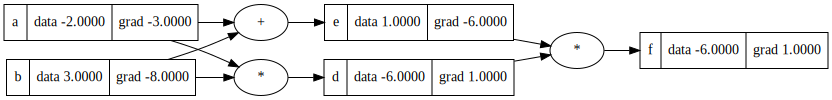

In [158]:
a = value(-2.0, label = 'a')
b = value(3.0, label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward ()

draw_dot(f)